# 1. Setting Up the Environment
We begin by downloading the Fashion Product Images dataset and importing all necessary libraries such as `PyTorch`, `NumPy`, `Pandas`, and others. The Kaggle dataset is downloaded using the `kagglehub` library.



In [1]:
import os
import json
from collections import Counter
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
import kagglehub

dataset_path = kagglehub.dataset_download('paramaggarwal/fashion-product-images-small')

print('Data source import complete.')

Data source import complete.


# 3. Dataset and Dataloader
We will import the dataset from the `data_loader` module and the vocabulary from its own module. Each image is loaded and the corresponding caption is tokenized using the vocabulary. We will also define the `CapsCollate` class for handling batches in a data loader.




In [2]:
from data_loader import FashionProductDataset
from vocabulary import Vocabulary

def get_data_loader(dataset, vocab, batch_size, shuffle=False, num_workers=1):
    pad_idx = vocab.stoi["<PAD>"]
    collate_fn = CapsCollate(pad_idx=pad_idx, batch_first=True)

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )
    return data_loader

In [3]:
class CapsCollate:
    def __init__(self, pad_idx, batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)

        targets = [item[1] for item in batch]
        targets = pad_sequence(
            targets, batch_first=self.batch_first, padding_value=self.pad_idx
        )
        return imgs, targets

In [4]:
BASE_DIRECTORY = "/root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1"

# 5. Data Transformation and Splitting
We will apply transformations such as resizing, cropping, normalization, and augmentation to the images. Augmentations like random cropping and color jittering increase dataset diversity. We will also split the dataset into training, validation, and test sets.

In [5]:
BATCH_SIZE = 32
NUM_WORKER = 4

train_transforms = T.Compose(
    [
        T.Resize((256, 256)),
        T.RandomCrop((224, 224)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=15),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

transforms = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


dataset = FashionProductDataset(
    root_dir=BASE_DIRECTORY + "/images",
    caption_file=BASE_DIRECTORY + "/styles.csv",
    transform=transforms,
)

total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size


train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# writing the dataloader
train_dataloader = get_data_loader(
    dataset=train_dataset,
    vocab=dataset.vocab,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
)
val_dataloader = get_data_loader(
    dataset=val_dataset,
    vocab=dataset.vocab,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
)

test_dataloader = get_data_loader(
    dataset=test_dataset,
    vocab=dataset.vocab,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
)


vocab_size = len(dataset.vocab)
print(vocab_size)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

4825


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


device(type='cuda', index=0)

# 4. Helper functions
We will define some utility functions such as the `read_image` function which handles images, while the `show_image` function unnormalizes and displays images alongside captions. These functions are used during model interpretation to ensure the outputs are visually inspectable.



In [6]:
def read_image(path):
    return Image.open(path)


def show_image(img, title=None):
    """Imshow for Tensor."""

    # unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))

    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# 8. Model Initialization
The model is instantiated with the specified dimensions for embedding size, attention layers, and LSTM hidden states. The loss function, `CrossEntropyLoss`, is configured to ignore padding tokens, and the `Adam` optimizer is initialized with a learning rate of `3e-4`.

In [7]:
from model import Model

In [8]:
embed_size = 300
vocab_size = len(dataset.vocab)
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512
learning_rate = 3e-4

In [9]:
model = Model(
    embed_size=300,
    vocab_size=len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512,
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"], label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# 9. Saving and Loading Checkpoints
Checkpointing is critical for saving model states and training metrics. Functions are defined to save and load model weights, optimizer states, and epoch metrics, enabling resumption of training from any saved point. This feature ensures that progress is not lost due to interruptions.

In [10]:
def save_checkpoint(state, filename="/kaggle/working/checkpoint.pth.tar"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(state, filename)


def load_checkpoint(model, optimizer, filename="/kaggle/working/checkpoint.pth.tar"):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]

    return model, optimizer, epoch, loss


def save_epoch_metrics(epoch_metrics_dict, filename):
    with open(filename, "w") as f:
        json.dump(epoch_metrics_dict, f)


def load_epoch_metrics(filename):
    with open(filename, "r") as f:
        epoch_metrics_dict = json.load(f)
    return epoch_metrics_dict

In [11]:
epoch_metrics_dict = {}


def reverse_process_caption(caption):
    ls = [dataset.vocab.itos[idx.item()] for idx in caption]
    ls = [word for word in ls if word not in ["<PAD>", "<SOS>", "<EOS>"]]
    return " ".join(ls)

# 10. Training and Validation
Train the model, validate on the validation set, and log metrics like loss and BLEU scores at each epoch.



In [ ]:
resume_training = False
start_epoch = 1
if resume_training:
    start_epoch, best_loss = load_checkpoint("/kaggle/working/checkpoint.pth.tar")
    loaded_dict = load_epoch_metrics("/kaggle/working/epoch_metrics.json")
num_epochs = 15
print_every = 938

for epoch in range(start_epoch, num_epochs + 1):
    teacher_forcing_ratio = max(0.5, 1.0 - (epoch - 1) * 0.03)

    progress_bar = tqdm(
        enumerate(iter(train_dataloader)), total=len(train_dataloader), leave=False
    )
    for idx, (image, captions) in progress_bar:
        image, captions = image.to(device), captions.to(device)

        optimizer.zero_grad()

        outputs, attentions = model(image, captions, teacher_forcing_ratio)

        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        if epoch not in epoch_metrics_dict:
            epoch_metrics_dict[epoch] = {}
        if (idx + 1) % print_every == 0:
            epoch_metrics_dict[epoch]["train_loss"] = loss.item()

        optimizer.step()
        progress_bar.set_description(f"Epoch: {epoch} Loss: {loss.item():.5f}")

    progress_bar.close()

    model.eval()
    val_loss = 0
    all_references = []
    all_hypotheses = []
    with torch.no_grad():
        for idxx, (image, captions) in enumerate(val_dataloader):
            image, captions = image.to(device), captions.to(device)
            outputs, attentions = model(image, captions)
            targets = captions[:, 1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            val_loss += loss.item()

            for i in range(image.shape[0]):
                ref_tokens = reverse_process_caption(captions[i])
                all_references.append([ref_tokens.split()])

                features = model.encoder(image[i : i + 1])
                caps, alphas = model.decoder.generate_caption_beam(
                    features, beam_size=3, vocab=dataset.vocab
                )
                caption_tokens = [tok for tok in caps if tok not in ["<PAD>", "<SOS>", "<EOS>"]]
                all_hypotheses.append(caption_tokens)

        val_loss /= len(val_dataloader)
        epoch_metrics_dict[epoch]["val_loss"] = val_loss
        print(f"Validation Loss: {val_loss}")

        from nltk.translate.bleu_score import SmoothingFunction
        smoothing_function = SmoothingFunction().method1
        bleu_score = corpus_bleu(all_references, all_hypotheses, smoothing_function=smoothing_function)

        print(f"Validation BLEU score: {bleu_score}")
        epoch_metrics_dict[epoch]["bleu_score"] = bleu_score

    scheduler.step(val_loss)
    model.train()

    save_checkpoint(
        {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss.item(),
        },
        filename="/kaggle/working/checkpoint.pth.tar",
    )
    save_epoch_metrics(epoch_metrics_dict, "/kaggle/working/epoch_metrics.json")

Validation Loss: 3.245365801475031
Validation BLEU score: 0.1007524601399967


Validation Loss: 2.958185849429892
Validation BLEU score: 0.11292356390091195


Validation Loss: 2.816568589038986
Validation BLEU score: 0.1193218400565231


Validation Loss: 2.7478121561969786
Validation BLEU score: 0.11641633608485444


Validation Loss: 2.6861521683150915
Validation BLEU score: 0.12397561570660967


Validation Loss: 2.649542062402629
Validation BLEU score: 0.12038693598440171


Validation Loss: 2.620514567807424
Validation BLEU score: 0.12493732516009223


Validation Loss: 2.58863044642716
Validation BLEU score: 0.12813360662672346


Validation Loss: 2.5837136001038035
Validation BLEU score: 0.12934342891347658


Validation Loss: 2.576010107136459
Validation BLEU score: 0.1334043300013189


Validation Loss: 2.5653106737479887
Validation BLEU score: 0.1280841107953435


Validation Loss: 2.560481532872152
Validation BLEU score: 0.1252597422736373


Validation Loss: 2.560620433134998
Validation BLEU score: 0.1266317650826933


Validation Loss: 2.574440168819839
Validation BLEU score: 0.13536216312317972


# 11. Visualizing Metrics
Metrics such as training loss, validation loss, and BLEU scores are plotted against epochs, providing insights into model convergence and generalization.

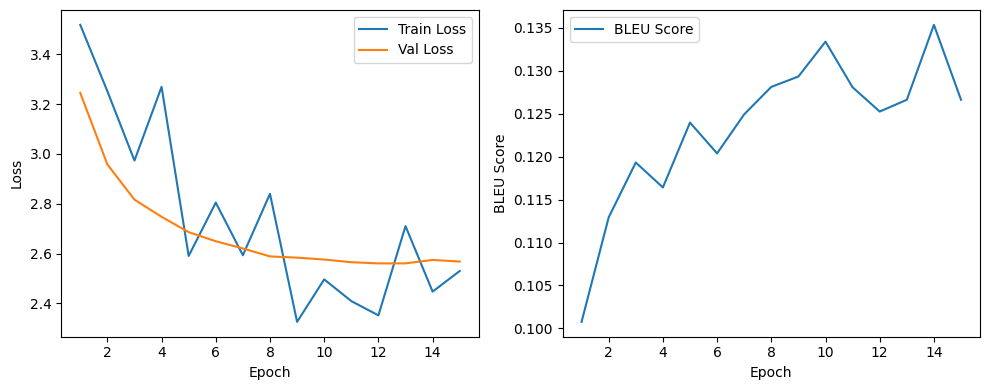

In [20]:
# Extract the metrics
epochs = list(epoch_metrics_dict.keys())
train_losses = [epoch_metrics_dict[epoch]["train_loss"] for epoch in epochs]
val_losses = [epoch_metrics_dict[epoch]["val_loss"] for epoch in epochs]
bleu_scores = [epoch_metrics_dict[epoch]["bleu_score"] for epoch in epochs]

# Plot the losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot the BLEU scores
plt.subplot(1, 2, 2)
plt.plot(epochs, bleu_scores, label="BLEU Score")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.legend()

plt.tight_layout()
plt.show()

# 12. Testing and Generating Captions
The trained model is evaluated on the test set, and captions are generated for sample images. This stage showcases the model's ability to describe images in natural language. Functions are defined to generate captions and visualize results, helping interpret model outputs.

In [21]:
# generate caption
def get_caps_from(features_tensors):
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps, alphas = model.decoder.generate_caption_beam(features, beam_size=3, vocab=dataset.vocab)
        caption = " ".join(caps)
    return caps, alphas


def get_caps_from_show(features_tensors):
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps, alphas = model.decoder.generate_caption_beam(features, beam_size=3, vocab=dataset.vocab)
        caption = " ".join(caps)
        show_image(features_tensors[0], title=caption)
    return caps, alphas

In [22]:
bleu_scores = []
for idx, (images, captions) in enumerate(iter(test_dataloader)):
    all_references = []
    all_hypotheses = []
    for caption in captions:
        ref_tokens = [dataset.vocab.itos[idx.item()] for idx in caption]
        ref_tokens = [tok for tok in ref_tokens if tok not in ["<PAD>", "<SOS>", "<EOS>"]]
        all_references.append([ref_tokens])
    for i in range(images.shape[0]):
        img = images[i].detach().clone()
        caps, alphas = get_caps_from(img.unsqueeze(0))
        caps = [tok for tok in caps if tok not in ["<PAD>", "<SOS>", "<EOS>"]]
        all_hypotheses.append(caps)
    from nltk.translate.bleu_score import SmoothingFunction
    smoother = SmoothingFunction().method4
    bleu_score = corpus_bleu(all_references, all_hypotheses, smoothing_function=smoother)
    bleu_scores.append(bleu_score)

In [23]:
bleu_scores = np.array(bleu_scores)
print(np.mean(bleu_scores))

0.12487146965586704


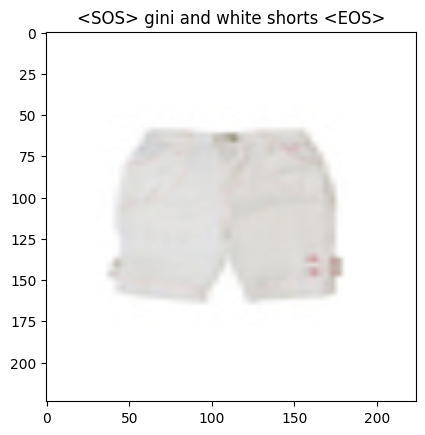

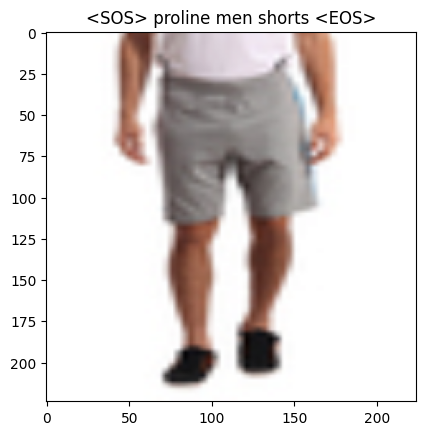

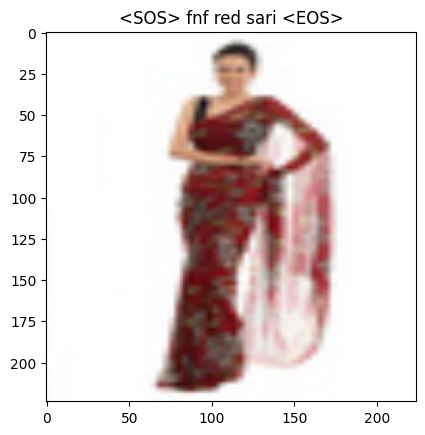

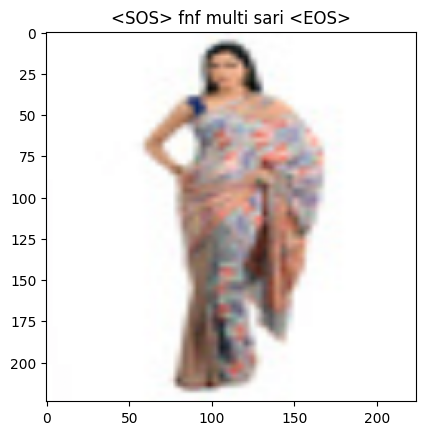

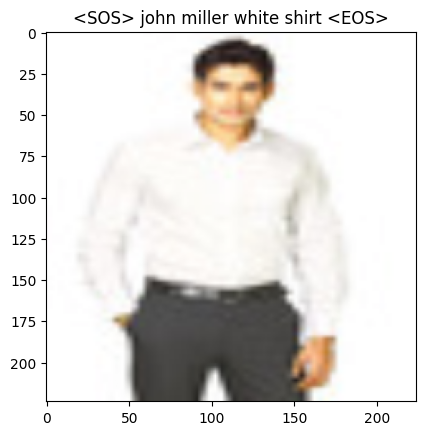

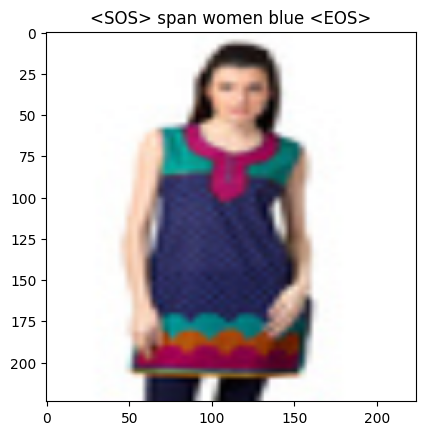

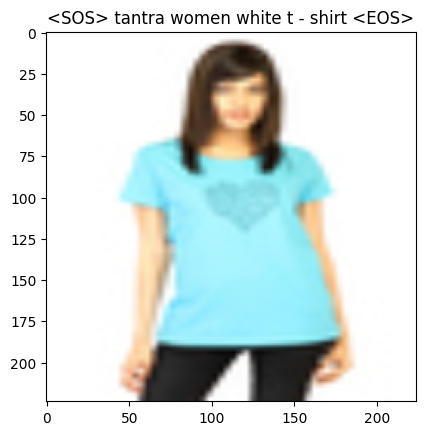

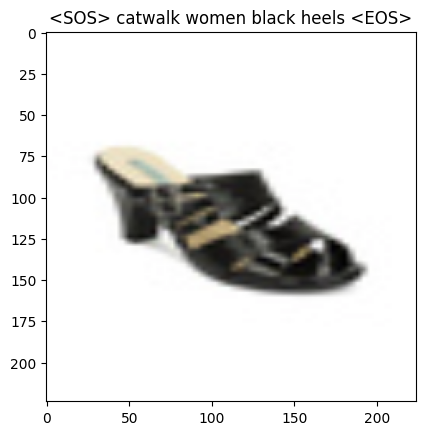

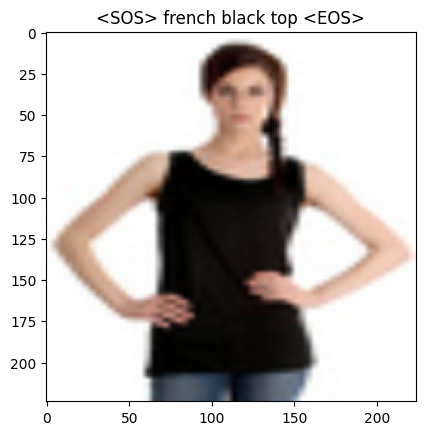

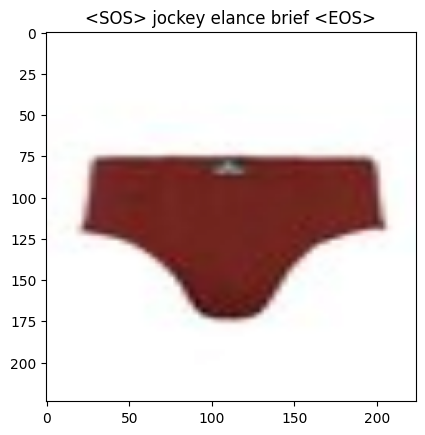

In [26]:
for i in range(20, 30):
    data_iter = iter(test_dataloader)
    images, caption = next(data_iter)
    img = images[i].detach().clone()
    caps, alphas = get_caps_from_show(img.unsqueeze(0))